# Wine Quality Analysis and Prediction using kNN Classifier built from scratch

---
## 0. Loading Libraries and Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt, matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import time
import collections
import numpy as np
import math
from IPython.display import Markdown, display
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import pairwise
from sklearn.preprocessing import label_binarize
from sklearn import metrics

COUNT = 1
DISTANCE_WEIGHTED = 2
EUCLID = 3
COSINE = 4

%matplotlib inline


def printmd(string):
    display(Markdown(string))

In [4]:
wine = pd.read_csv('winequality-red.csv', sep = ';')

       count
class       
High     855
Low      744


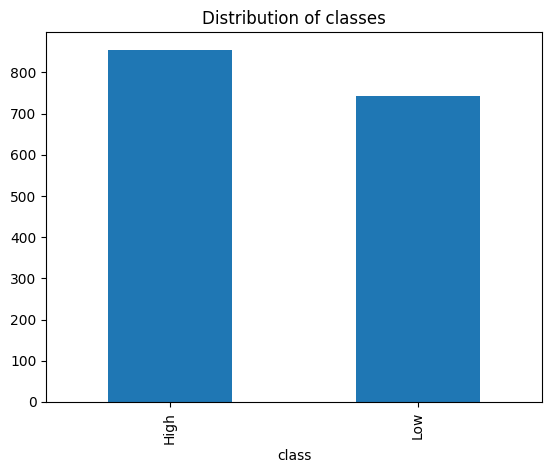

In [5]:
wine['class'] = ['Low' if i <= 5 else "High" for i in wine.quality]
wine['class'].value_counts().plot(kind = 'bar', title = 'Distribution of classes')
wine.drop(columns = ['quality'], inplace = True)
wine_data = wine[wine.columns[wine.columns != 'class']].copy()
wine_label = wine['class'].copy()
print(pd.DataFrame(wine_label.value_counts()))

In [6]:
printmd('## 2.1. Data Snapshot')
wine.head()

## 2.1. Data Snapshot

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol class  
0      9.4   Low  
1      9.8   Low  
2      9.8   Low  
3      9.8  High  
4      9.4   Low

In [7]:
printmd('## 2.2. Summary Statistics')
wine_data.describe()

## 2.2. Summary Statistics

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol  
count  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983  
std       0.154386     0.169507     1.065668  
min       2.740000     0.330000     8.400000  
25%       3.210000     0.550000     9.500000  
50%       3.310000     0.620000    10.200000  
75%       3.400000     0.730000    11.100000  
max       4.010000     2.000000    14.900000

In [8]:
printmd('## 2.3. Correlation Matrix')
wine_data.corr(method = 'pearson')

## 2.3. Correlation Matrix

fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000         -0.256131     0.671703   
volatile acidity          -0.256131          1.000000    -0.552496   
citric acid                0.671703         -0.552496     1.000000   
residual sugar             0.114777          0.001918     0.143577   
chlorides                  0.093705          0.061298     0.203823   
free sulfur dioxide       -0.153794         -0.010504    -0.060978   
total sulfur dioxide      -0.113181          0.076470     0.035533   
density                    0.668047          0.022026     0.364947   
pH                        -0.682978          0.234937    -0.541904   
sulphates                  0.183006         -0.260987     0.312770   
alcohol                   -0.061668         -0.202288     0.109903   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity               0.114777   0.093705            -0.153794   
volatile acidity            0.001918   0.061298            -0.010504   
citric acid                 0.143577   0.203823            -0.060978   
residual sugar              1.000000   0.055610             0.187049   
chlorides                   0.055610   1.000000             0.005562   
free sulfur dioxide         0.187049   0.005562             1.000000   
total sulfur dioxide        0.203028   0.047400             0.667666   
density                     0.355283   0.200632            -0.021946   
pH                         -0.085652  -0.265026             0.070377   
sulphates                   0.005527   0.371260             0.051658   
alcohol                     0.042075  -0.221141            -0.069408   

                      total sulfur dioxide   density        pH  sulphates  \
fixed acidity                    -0.113181  0.668047 -0.682978   0.183006   
volatile acidity                  0.076470  0.022026  0.234937  -0.260987   
citric acid                       0.035533  0.364947 -0.541904   0.312770   
residual sugar                    0.203028  0.355283 -0.085652   0.005527   
chlorides                         0.047400  0.200632 -0.265026   0.371260   
free sulfur dioxide               0.667666 -0.021946  0.070377   0.051658   
total sulfur dioxide              1.000000  0.071269 -0.066495   0.042947   
density                           0.071269  1.000000 -0.341699   0.148506   
pH                               -0.066495 -0.341699  1.000000  -0.196648   
sulphates                         0.042947  0.148506 -0.196648   1.000000   
alcohol                          -0.205654 -0.496180  0.205633   0.093595   

                       alcohol  
fixed acidity        -0.061668  
volatile acidity     -0.202288  
citric acid           0.109903  
residual sugar        0.042075  
chlorides            -0.221141  
free sulfur dioxide  -0.069408  
total sulfur dioxide -0.205654  
density              -0.496180  
pH                    0.205633  
sulphates             0.093595  
alcohol               1.000000

In [9]:
printmd('## 2.3.1 Top Correlated Pairs')
correlated_pairs = wine_data.corr()
top_correlated_pairs = correlated_pairs.unstack().sort_values(kind="quicksort")
pd.DataFrame(top_correlated_pairs[((top_correlated_pairs < -0.5) & (top_correlated_pairs > -1)) | ((top_correlated_pairs>0.5) & (top_correlated_pairs <1))], columns = ['Coefficient'])

## 2.3.1 Top Correlated Pairs

Coefficient
pH                   fixed acidity           -0.682978
fixed acidity        pH                      -0.682978
volatile acidity     citric acid             -0.552496
citric acid          volatile acidity        -0.552496
pH                   citric acid             -0.541904
citric acid          pH                      -0.541904
free sulfur dioxide  total sulfur dioxide     0.667666
total sulfur dioxide free sulfur dioxide      0.667666
density              fixed acidity            0.668047
fixed acidity        density                  0.668047
citric acid          fixed acidity            0.671703
fixed acidity        citric acid              0.671703

In [10]:
wine_data.drop(columns = ['fixed acidity','total sulfur dioxide'], inplace = True)

## Boxplot

<Axes: title={'center': 'Boxplot'}>

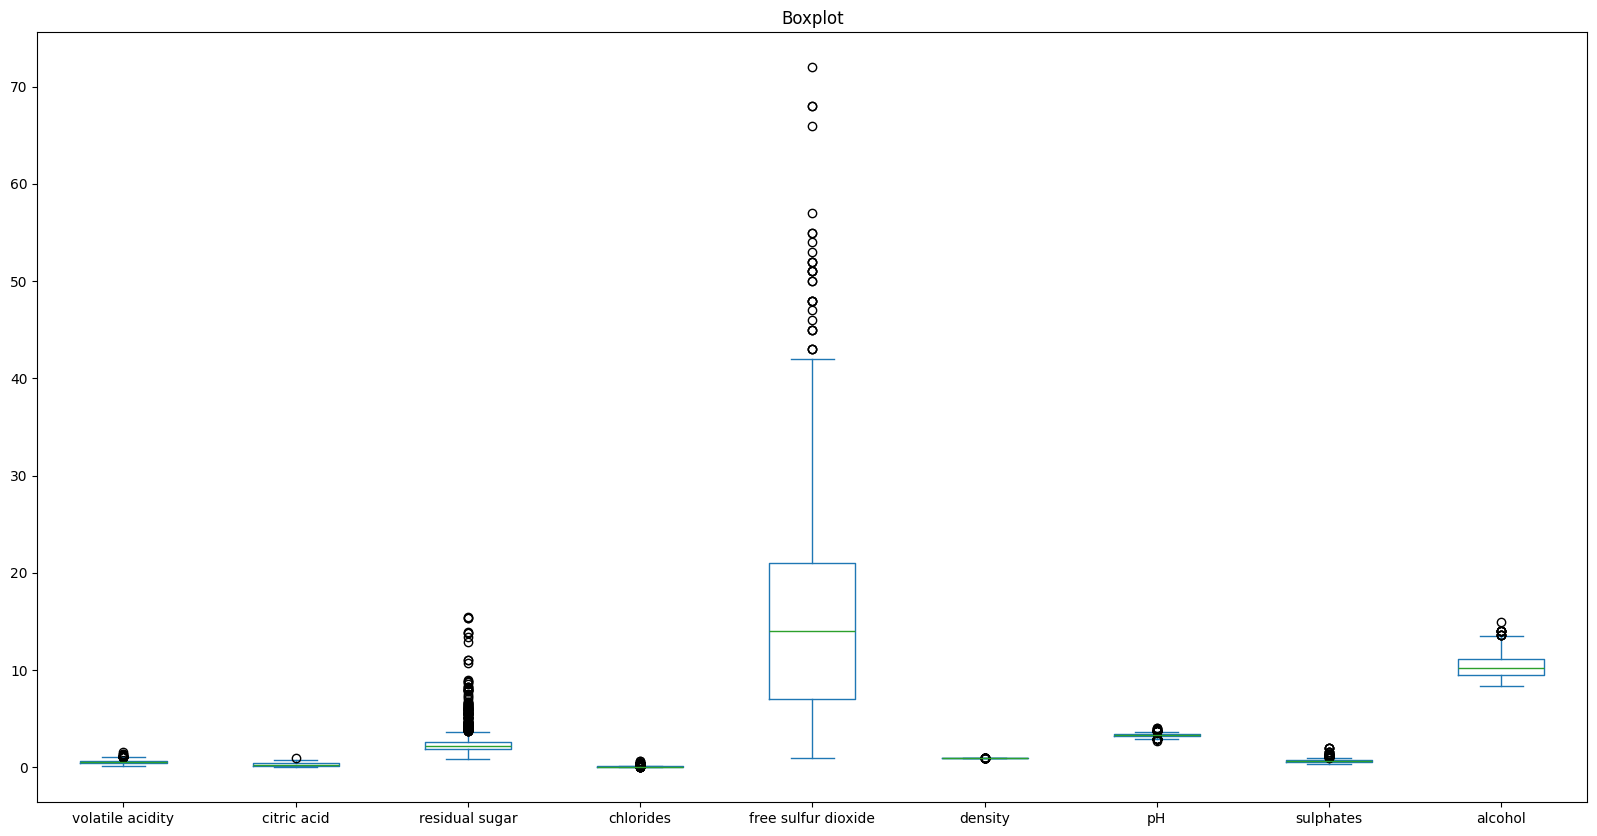

In [11]:
printmd('## Boxplot')
wine_data.plot(kind = 'box', figsize = (20,10), title = 'Boxplot')

## Outlier Analysis

### Boxplot

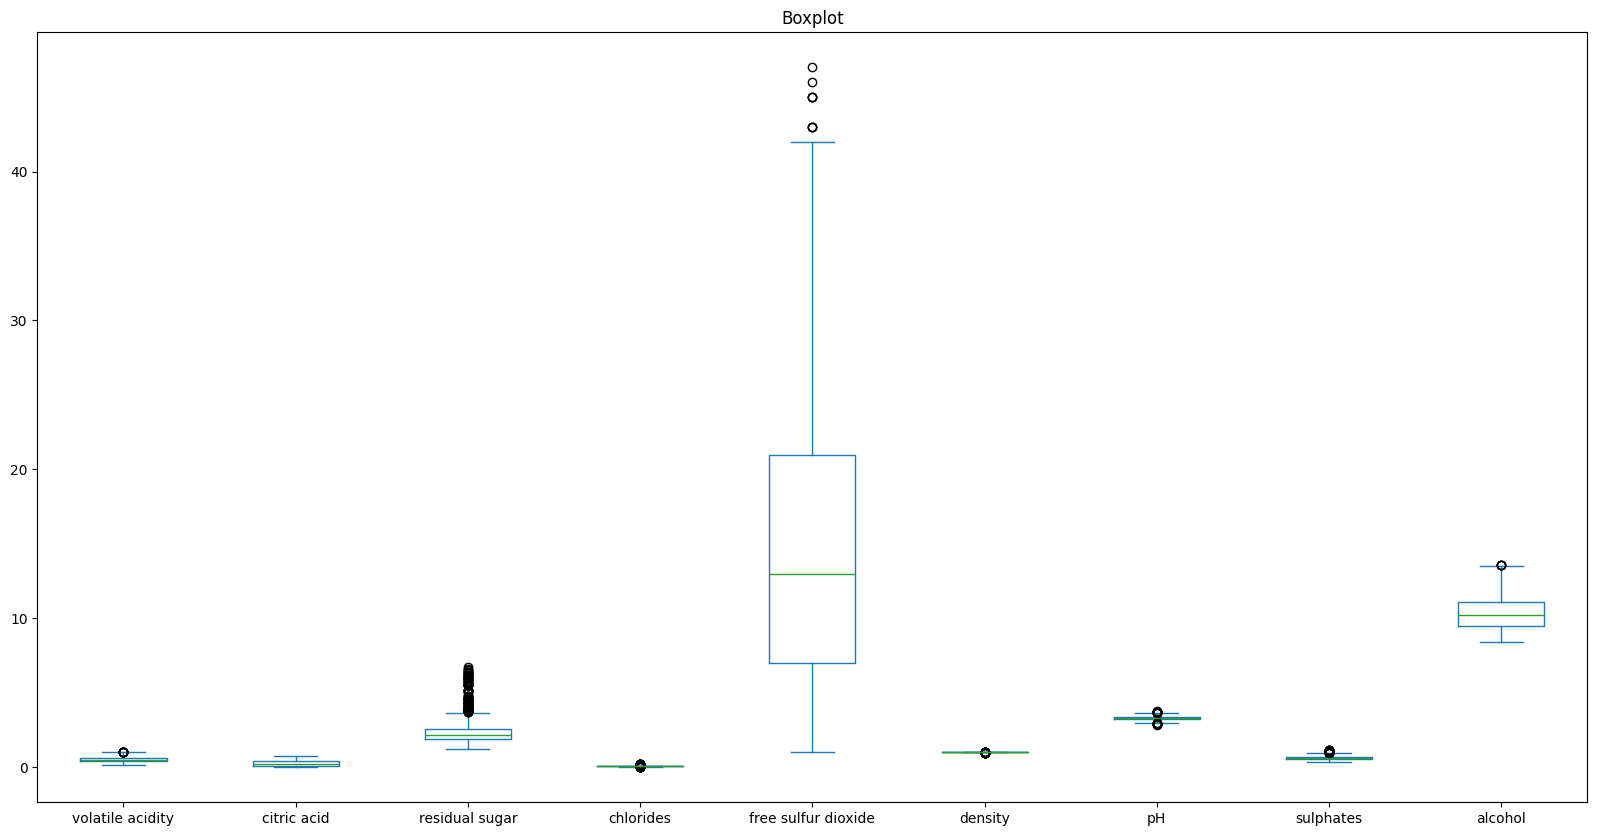

In [12]:
printmd('## Outlier Analysis')
outlier_filter = (np.abs(wine_data - wine_data.mean()) <= (3*wine_data.std())).all(1)
wine_data = wine_data[outlier_filter] 
wine_label = wine_label[outlier_filter]

printmd('### Boxplot')
wine_data.plot(kind = 'box', figsize = (20,10), title = 'Boxplot')
print()

In [13]:
X = np.array(wine_data)
y = np.array(wine_label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
def euclidian_distance(A, B):
    if not (A.ndim == 1 and B.ndim == 1):
        raise ValueError("Both numpy arrays should be single rows (1 dimensional).")
    return np.sqrt(np.sum(np.square(A - B)))

def cosine_similarity(A, B):
    if not (A.ndim == 1 and B.ndim == 1):
        raise ValueError("Both numpy arrays should be single rows (1 dimensional).")
    return np.sum(A*B)/(np.sqrt(np.sum(A*A)) * np.sqrt(np.sum(B*B)))


def predict(train_X, labels, test, K, metric, measure):
    distances = []
    for i, sample in enumerate(train_X):
        if measure == EUCLID:
            distance = euclidian_distance(sample, test)
        elif measure == COSINE:
            distance = cosine_similarity(sample, test)
        distances.append((distance, i))

    distances.sort()

    return predict_label(distances, labels, K, metric, measure)

def predict_label(distances, labels, K, metric, measure):
    if metric == COUNT:
        k_closest = [labels[x[1]] for x in distances[:K]]
        counts = collections.Counter(k_closest)
        return counts.most_common()[0][0], counts.most_common()[0][1] / K
    if metric == DISTANCE_WEIGHTED:
        label_sum = {}
        max_sum = -1
        count = 0
        for distance, index in distances:
            if distance == 0: continue
            if count == K: break
            count += 1
            label_sum[labels[index]] = label_sum.get(labels[index], 0) + (1 / distance)
            if label_sum[labels[index]] > max_sum:
                max_sum = label_sum[labels[index]]
                predicted_label = labels[index]
        return predicted_label, max_sum / sum(label_sum.values())
    
def kNN(X_train, y_train, X_test, y_test, K, metric, measure):
    predicted = []
    for i, test in enumerate(X_test):
        predicted_class, posterior = predict(X_train, y_train, test, K, metric, measure)
        actual_class = y_test[i]
        predicted.append((actual_class, predicted_class, posterior))
    
    prediction = pd.DataFrame.from_records(predicted, columns=["Actual", "Predicted", "Posterior"])
    
    return prediction

def get_accuracy(prediction_df):
    return prediction_df[prediction_df["Actual"] == prediction_df["Predicted"]].shape[0] / prediction_df.shape[0]

In [15]:
def optimal_K(metric, measure):
    K_candidates = range(1,50,2)
    errors = []
    for K in K_candidates:
        accuracy = get_accuracy(kNN(X_train, y_train, X_test, y_test, K, metric, measure))
        errors.append(1 - accuracy)
    
    plt.plot(K_candidates, errors)
    plt.show()
    return np.where(errors==np.min(errors))

In [16]:
def confusion_matrix(prediction_df):
    y = list(prediction_df.Actual)
    x = list(prediction_df.Predicted)
    if len(x) != len(y):
        return 'Length do not match'
    TP, TN, FP, FN = 0,0,0,0
    for i in range(len(x)):
        if y[i] == 'High':
            if x[i] == 'High':
                TP += 1
            else:
                FN += 1
        else:
            if x[i] == 'High':
                FP += 1
            else:
                TN += 1
    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    return accuracy, precision, recall, f_measure, sensitivity, specificity, error_rate

def optimal_K_confusion(metric, measure):
    K_candidates = range(1,50,2)
    out = {}
    for K in K_candidates:
        accuracy, precision, recall, f_measure, sensitivity, specificity, error_rate = confusion_matrix(kNN(X_train, y_train, X_test, y_test, K, metric, measure))
        out['K'] = out.get('K',[]) + [K]
        out['f_measure'] = out.get('f_measure',[]) + [f_measure]
        out['sensitivity'] = out.get('sensitivity',[]) + [sensitivity]
        out['specificity'] = out.get('specificity',[]) + [specificity]
        out['error_rate'] = out.get('error_rate',[]) + [error_rate]
        out['accuracy'] = out.get('accuracy',[]) + [accuracy]
        out['precision'] = out.get('precision',[]) + [precision]
        out['recall'] = out.get('recall',[]) + [recall]
        
    return pd.DataFrame(out)



In [17]:
printmd('### 6.1. kNN using COUNT method and Euclidean distance as proximity measure')
base_count_euclid = optimal_K_confusion(COUNT, EUCLID)
base_count_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.1. kNN using COUNT method and Euclidean distance as proximity measure

K  f_measure  sensitivity  specificity  error_rate  accuracy  precision  \
0    1   0.779412     0.753555     0.759494    0.243902  0.756098   0.807107   
11  23   0.698565     0.691943     0.613924    0.341463  0.658537   0.705314   
17  35   0.695431     0.649289     0.708861    0.325203  0.674797   0.748634   
15  31   0.694789     0.663507     0.670886    0.333333  0.666667   0.729167   
19  39   0.693467     0.654028     0.689873    0.330623  0.669377   0.737968   
14  29   0.693069     0.663507     0.664557    0.336043  0.663957   0.725389   
13  27   0.692875     0.668246     0.651899    0.338753  0.661247   0.719388   
1    3   0.692683     0.672986     0.639241    0.341463  0.658537   0.713568   
10  21   0.692308     0.682464     0.613924    0.346883  0.653117   0.702439   
18  37   0.692112     0.644550     0.708861    0.327913  0.672087   0.747253   
2    5   0.690821     0.677725     0.620253    0.346883  0.653117   0.704433   
7   15   0.687651     0.672986     0.620253    0.349593  0.650407   0.702970   
20  41   0.686869     0.644550     0.689873    0.336043  0.663957   0.735135   
8   17   0.684597     0.663507     0.632911    0.349593  0.650407   0.707071   
12  25   0.684597     0.663507     0.632911    0.349593  0.650407   0.707071   
5   11   0.684337     0.672986     0.607595    0.355014  0.644986   0.696078   
9   19   0.684337     0.672986     0.607595    0.355014  0.644986   0.696078   
3    7   0.684211     0.677725     0.594937    0.357724  0.642276   0.690821   
16  33   0.683417     0.644550     0.677215    0.341463  0.658537   0.727273   
21  43   0.678481     0.635071     0.683544    0.344173  0.655827   0.728261   
22  45   0.678481     0.635071     0.683544    0.344173  0.655827   0.728261   
6   13   0.677966     0.663507     0.607595    0.360434  0.639566   0.693069   
23  47   0.675258     0.620853     0.708861    0.341463  0.658537   0.740113   
4    9   0.658537     0.639810     0.594937    0.379404  0.620596   0.678392   
24  49   0.657963     0.597156     0.708861    0.355014  0.644986   0.732558   

      recall  
0   0.753555  
11  0.691943  
17  0.649289  
15  0.663507  
19  0.654028  
14  0.663507  
13  0.668246  
1   0.672986  
10  0.682464  
18  0.644550  
2   0.677725  
7   0.672986  
20  0.644550  
8   0.663507  
12  0.663507  
5   0.672986  
9   0.672986  
3   0.677725  
16  0.644550  
21  0.635071  
22  0.635071  
6   0.663507  
23  0.620853  
4   0.639810  
24  0.597156

In [18]:
printmd('### 6.2. kNN using COUNT method and Cosine distance as proximity measure')
base_count_cosine = optimal_K_confusion(COUNT, COSINE)
base_count_cosine.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.2. kNN using COUNT method and Cosine distance as proximity measure

K  f_measure  sensitivity  specificity  error_rate  accuracy  precision  \
0    1   0.570776     0.592417     0.354430    0.509485  0.490515   0.550661   
19  39   0.562791     0.573460     0.379747    0.509485  0.490515   0.552511   
20  41   0.562791     0.573460     0.379747    0.509485  0.490515   0.552511   
23  47   0.562791     0.573460     0.379747    0.509485  0.490515   0.552511   
21  43   0.561485     0.573460     0.373418    0.512195  0.487805   0.550000   
22  45   0.561485     0.573460     0.373418    0.512195  0.487805   0.550000   
18  37   0.559441     0.568720     0.379747    0.512195  0.487805   0.550459   
24  49   0.559441     0.568720     0.379747    0.512195  0.487805   0.550459   
12  25   0.557377     0.563981     0.386076    0.512195  0.487805   0.550926   
13  27   0.557377     0.563981     0.386076    0.512195  0.487805   0.550926   
14  29   0.557377     0.563981     0.386076    0.512195  0.487805   0.550926   
4    9   0.556604     0.559242     0.398734    0.509485  0.490515   0.553991   
5   11   0.556604     0.559242     0.398734    0.509485  0.490515   0.553991   
6   13   0.556604     0.559242     0.398734    0.509485  0.490515   0.553991   
7   15   0.556604     0.559242     0.398734    0.509485  0.490515   0.553991   
8   17   0.556604     0.559242     0.398734    0.509485  0.490515   0.553991   
10  21   0.556604     0.559242     0.398734    0.509485  0.490515   0.553991   
9   19   0.555294     0.559242     0.392405    0.512195  0.487805   0.551402   
11  23   0.553991     0.559242     0.386076    0.514905  0.485095   0.548837   
15  31   0.553991     0.559242     0.386076    0.514905  0.485095   0.548837   
16  33   0.553991     0.559242     0.386076    0.514905  0.485095   0.548837   
17  35   0.553991     0.559242     0.386076    0.514905  0.485095   0.548837   
3    7   0.351275     0.293839     0.493671    0.620596  0.379404   0.436620   
1    3   0.320000     0.246445     0.607595    0.598916  0.401084   0.456140   
2    5   0.101562     0.061611     0.797468    0.623306  0.376694   0.288889   

      recall  
0   0.592417  
19  0.573460  
20  0.573460  
23  0.573460  
21  0.573460  
22  0.573460  
18  0.568720  
24  0.568720  
12  0.563981  
13  0.563981  
14  0.563981  
4   0.559242  
5   0.559242  
6   0.559242  
7   0.559242  
8   0.559242  
10  0.559242  
9   0.559242  
11  0.559242  
15  0.559242  
16  0.559242  
17  0.559242  
3   0.293839  
1   0.246445  
2   0.061611

In [19]:
printmd('### 6.3. kNN using Weighted Distance method and Euclidean distance as proximity measure')
base_DW_euclid = optimal_K_confusion(DISTANCE_WEIGHTED, EUCLID)
base_DW_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.3. kNN using Weighted Distance method and Euclidean distance as proximity measure

K  f_measure  sensitivity  specificity  error_rate  accuracy  precision  \
19  39   0.696742     0.658768     0.689873    0.327913  0.672087   0.739362   
20  41   0.696517     0.663507     0.677215    0.330623  0.669377   0.732984   
21  43   0.695000     0.658768     0.683544    0.330623  0.669377   0.735450   
18  37   0.688442     0.649289     0.683544    0.336043  0.663957   0.732620   
22  45   0.688442     0.649289     0.683544    0.336043  0.663957   0.732620   
8   17   0.687500     0.677725     0.607595    0.352304  0.647696   0.697561   
0    1   0.686420     0.658768     0.651899    0.344173  0.655827   0.716495   
11  23   0.685851     0.677725     0.601266    0.355014  0.644986   0.694175   
17  35   0.685139     0.644550     0.683544    0.338753  0.661247   0.731183   
23  47   0.681704     0.644550     0.670886    0.344173  0.655827   0.723404   
7   15   0.681159     0.668246     0.607595    0.357724  0.642276   0.694581   
9   19   0.681159     0.668246     0.607595    0.357724  0.642276   0.694581   
16  33   0.680000     0.644550     0.664557    0.346883  0.653117   0.719577   
6   13   0.679612     0.663507     0.613924    0.357724  0.642276   0.696517   
2    5   0.679426     0.672986     0.588608    0.363144  0.636856   0.685990   
12  25   0.676329     0.663507     0.601266    0.363144  0.636856   0.689655   
10  21   0.676259     0.668246     0.588608    0.365854  0.634146   0.684466   
13  27   0.674817     0.654028     0.620253    0.360434  0.639566   0.696970   
1    3   0.674699     0.663507     0.594937    0.365854  0.634146   0.686275   
14  29   0.673267     0.644550     0.639241    0.357724  0.642276   0.704663   
5   11   0.673171     0.654028     0.613924    0.363144  0.636856   0.693467   
24  49   0.671756     0.625592     0.683544    0.349593  0.650407   0.725275   
3    7   0.671429     0.668246     0.569620    0.373984  0.626016   0.674641   
15  31   0.666667     0.639810     0.626582    0.365854  0.634146   0.695876   
4    9   0.658596     0.644550     0.582278    0.382114  0.617886   0.673267   

      recall  
19  0.658768  
20  0.663507  
21  0.658768  
18  0.649289  
22  0.649289  
8   0.677725  
0   0.658768  
11  0.677725  
17  0.644550  
23  0.644550  
7   0.668246  
9   0.668246  
16  0.644550  
6   0.663507  
2   0.672986  
12  0.663507  
10  0.668246  
13  0.654028  
1   0.663507  
14  0.644550  
5   0.654028  
24  0.625592  
3   0.668246  
15  0.639810  
4   0.644550

In [20]:
printmd('### 6.4. kNN using Weighted Distance method and Cosine distance as proximity measure')
base_DW_cosine = optimal_K_confusion(DISTANCE_WEIGHTED, COSINE)
base_DW_cosine.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.4. kNN using Weighted Distance method and Cosine distance as proximity measure

K  f_measure  sensitivity  specificity  error_rate  accuracy  precision  \
0    1   0.570776     0.592417     0.354430    0.509485  0.490515   0.550661   
19  39   0.562791     0.573460     0.379747    0.509485  0.490515   0.552511   
20  41   0.562791     0.573460     0.379747    0.509485  0.490515   0.552511   
23  47   0.562791     0.573460     0.379747    0.509485  0.490515   0.552511   
21  43   0.561485     0.573460     0.373418    0.512195  0.487805   0.550000   
22  45   0.561485     0.573460     0.373418    0.512195  0.487805   0.550000   
18  37   0.559441     0.568720     0.379747    0.512195  0.487805   0.550459   
24  49   0.559441     0.568720     0.379747    0.512195  0.487805   0.550459   
12  25   0.557377     0.563981     0.386076    0.512195  0.487805   0.550926   
13  27   0.557377     0.563981     0.386076    0.512195  0.487805   0.550926   
14  29   0.557377     0.563981     0.386076    0.512195  0.487805   0.550926   
4    9   0.556604     0.559242     0.398734    0.509485  0.490515   0.553991   
5   11   0.556604     0.559242     0.398734    0.509485  0.490515   0.553991   
6   13   0.556604     0.559242     0.398734    0.509485  0.490515   0.553991   
7   15   0.556604     0.559242     0.398734    0.509485  0.490515   0.553991   
8   17   0.556604     0.559242     0.398734    0.509485  0.490515   0.553991   
10  21   0.556604     0.559242     0.398734    0.509485  0.490515   0.553991   
9   19   0.555294     0.559242     0.392405    0.512195  0.487805   0.551402   
11  23   0.553991     0.559242     0.386076    0.514905  0.485095   0.548837   
15  31   0.553991     0.559242     0.386076    0.514905  0.485095   0.548837   
16  33   0.553991     0.559242     0.386076    0.514905  0.485095   0.548837   
17  35   0.553991     0.559242     0.386076    0.514905  0.485095   0.548837   
3    7   0.351275     0.293839     0.493671    0.620596  0.379404   0.436620   
1    3   0.320000     0.246445     0.607595    0.598916  0.401084   0.456140   
2    5   0.101562     0.061611     0.797468    0.623306  0.376694   0.288889   

      recall  
0   0.592417  
19  0.573460  
20  0.573460  
23  0.573460  
21  0.573460  
22  0.573460  
18  0.568720  
24  0.568720  
12  0.563981  
13  0.563981  
14  0.563981  
4   0.559242  
5   0.559242  
6   0.559242  
7   0.559242  
8   0.559242  
10  0.559242  
9   0.559242  
11  0.559242  
15  0.559242  
16  0.559242  
17  0.559242  
3   0.293839  
1   0.246445  
2   0.061611

In [21]:
printmd('### Normalizing the data using mix-max method')
X_train, X_test, Y_train, Y_test = train_test_split(wine_data, wine_label, test_size=0.25, random_state=42)
X_train_norm = (X_train - X_train.min()) / (X_train.max() -  X_train.min())
X_test_norm = (X_test - X_train.min()) / (X_train.max() -  X_train.min())
X_train = np.array(X_train_norm)
X_test = np.array(X_test_norm)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


### Normalizing the data using mix-max method

In [22]:
printmd('### 6.5. kNN using COUNT method and Euclidean distance as proximity measure on Normalized Data')
norm_count_euclid = optimal_K_confusion(COUNT, EUCLID)
norm_count_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.5. kNN using COUNT method and Euclidean distance as proximity measure on Normalized Data

K  f_measure  sensitivity  specificity  error_rate  accuracy  precision  \
4    9   0.758950     0.753555     0.689873    0.273713  0.726287   0.764423   
22  45   0.754902     0.729858     0.727848    0.271003  0.728997   0.781726   
23  47   0.751843     0.725118     0.727848    0.273713  0.726287   0.780612   
6   13   0.751807     0.739336     0.696203    0.279133  0.720867   0.764706   
21  43   0.751220     0.729858     0.715190    0.276423  0.723577   0.773869   
13  27   0.749403     0.744076     0.677215    0.284553  0.715447   0.754808   
2    5   0.748815     0.748815     0.664557    0.287263  0.712737   0.748815   
12  25   0.748792     0.734597     0.696203    0.281843  0.718157   0.763547   
24  49   0.748768     0.720379     0.727848    0.276423  0.723577   0.779487   
17  35   0.748201     0.739336     0.683544    0.284553  0.715447   0.757282   
19  39   0.747573     0.729858     0.702532    0.281843  0.718157   0.766169   
20  41   0.747573     0.729858     0.702532    0.281843  0.718157   0.766169   
5   11   0.747045     0.748815     0.658228    0.289973  0.710027   0.745283   
7   15   0.747045     0.748815     0.658228    0.289973  0.710027   0.745283   
14  29   0.745843     0.744076     0.664557    0.289973  0.710027   0.747619   
18  37   0.745763     0.729858     0.696203    0.284553  0.715447   0.762376   
8   17   0.743405     0.734597     0.677215    0.289973  0.710027   0.752427   
16  33   0.743405     0.734597     0.677215    0.289973  0.710027   0.752427   
15  31   0.742169     0.729858     0.683544    0.289973  0.710027   0.754902   
3    7   0.740047     0.748815     0.632911    0.300813  0.699187   0.731481   
9   19   0.739130     0.725118     0.683544    0.292683  0.707317   0.753695   
10  21   0.736077     0.720379     0.683544    0.295393  0.704607   0.752475   
11  23   0.735577     0.725118     0.670886    0.298103  0.701897   0.746341   
1    3   0.729017     0.720379     0.658228    0.306233  0.693767   0.737864   
0    1   0.726829     0.706161     0.683544    0.303523  0.696477   0.748744   

      recall  
4   0.753555  
22  0.729858  
23  0.725118  
6   0.739336  
21  0.729858  
13  0.744076  
2   0.748815  
12  0.734597  
24  0.720379  
17  0.739336  
19  0.729858  
20  0.729858  
5   0.748815  
7   0.748815  
14  0.744076  
18  0.729858  
8   0.734597  
16  0.734597  
15  0.729858  
3   0.748815  
9   0.725118  
10  0.720379  
11  0.725118  
1   0.720379  
0   0.706161

In [23]:
printmd('### 6.6. kNN using COUNT method and Cosine distance as proximity measure on Normalized Data')
norm_count_cosine = optimal_K_confusion(COUNT, COSINE)
norm_count_cosine.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.6. kNN using COUNT method and Cosine distance as proximity measure on Normalized Data

K  f_measure  sensitivity  specificity  error_rate  accuracy  precision  \
1    3   0.570297     0.682464     0.050633    0.588076  0.411924   0.489796   
0    1   0.560636     0.668246     0.044304    0.598916  0.401084   0.482877   
3    7   0.554217     0.654028     0.056962    0.601626  0.398374   0.480836   
2    5   0.552419     0.649289     0.063291    0.601626  0.398374   0.480702   
4    9   0.534161     0.611374     0.094937    0.609756  0.390244   0.474265   
5   11   0.522105     0.587678     0.113924    0.615176  0.384824   0.469697   
6   13   0.508475     0.568720     0.107595    0.628726  0.371274   0.459770   
7   15   0.505263     0.568720     0.088608    0.636856  0.363144   0.454545   
8   17   0.500000     0.563981     0.075949    0.644986  0.355014   0.449057   
15  31   0.496815     0.554502     0.094937    0.642276  0.357724   0.450000   
14  29   0.495798     0.559242     0.069620    0.650407  0.349593   0.445283   
12  25   0.494759     0.559242     0.063291    0.653117  0.346883   0.443609   
13  27   0.494715     0.554502     0.082278    0.647696  0.352304   0.446565   
18  37   0.490323     0.540284     0.113924    0.642276  0.357724   0.448819   
11  23   0.489451     0.549763     0.069620    0.655827  0.344173   0.441065   
19  39   0.488223     0.540284     0.101266    0.647696  0.352304   0.445312   
21  43   0.488223     0.540284     0.101266    0.647696  0.352304   0.445312   
17  35   0.484848     0.530806     0.120253    0.644986  0.355014   0.446215   
20  41   0.483940     0.535545     0.094937    0.653117  0.346883   0.441406   
9   19   0.482030     0.540284     0.063291    0.663957  0.336043   0.435115   
16  33   0.481720     0.530806     0.101266    0.653117  0.346883   0.440945   
23  47   0.478261     0.521327     0.120253    0.650407  0.349593   0.441767   
10  21   0.477612     0.530806     0.075949    0.663957  0.336043   0.434109   
22  45   0.472885     0.516588     0.107595    0.658537  0.341463   0.436000   
24  49   0.472648     0.511848     0.126582    0.653117  0.346883   0.439024   

      recall  
1   0.682464  
0   0.668246  
3   0.654028  
2   0.649289  
4   0.611374  
5   0.587678  
6   0.568720  
7   0.568720  
8   0.563981  
15  0.554502  
14  0.559242  
12  0.559242  
13  0.554502  
18  0.540284  
11  0.549763  
19  0.540284  
21  0.540284  
17  0.530806  
20  0.535545  
9   0.540284  
16  0.530806  
23  0.521327  
10  0.530806  
22  0.516588  
24  0.511848

In [24]:
printmd('### 6.7. kNN using Weighted Distance method and Euclidean distance as proximity measure on Normalized Data')
norm_DW_euclid = optimal_K_confusion(DISTANCE_WEIGHTED, EUCLID)
norm_DW_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.7. kNN using Weighted Distance method and Euclidean distance as proximity measure on Normalized Data

K  f_measure  sensitivity  specificity  error_rate  accuracy  precision  \
21  43   0.761446     0.748815     0.708861    0.268293  0.731707   0.774510   
8   17   0.760095     0.758294     0.683544    0.273713  0.726287   0.761905   
22  45   0.759804     0.734597     0.734177    0.265583  0.734417   0.786802   
6   13   0.758950     0.753555     0.689873    0.273713  0.726287   0.764423   
16  33   0.758950     0.753555     0.689873    0.273713  0.726287   0.764423   
18  37   0.758454     0.744076     0.708861    0.271003  0.728997   0.773399   
19  39   0.758454     0.744076     0.708861    0.271003  0.728997   0.773399   
13  27   0.758294     0.758294     0.677215    0.276423  0.723577   0.758294   
20  41   0.756627     0.744076     0.702532    0.273713  0.726287   0.769608   
12  25   0.755981     0.748815     0.689873    0.276423  0.723577   0.763285   
17  35   0.754808     0.744076     0.696203    0.276423  0.723577   0.765854   
23  47   0.753056     0.729858     0.721519    0.273713  0.726287   0.777778   
7   15   0.752941     0.758294     0.658228    0.284553  0.715447   0.747664   
14  29   0.752381     0.748815     0.677215    0.281843  0.718157   0.755981   
15  31   0.752381     0.748815     0.677215    0.281843  0.718157   0.755981   
24  49   0.750000     0.725118     0.721519    0.276423  0.723577   0.776650   
4    9   0.748815     0.748815     0.664557    0.287263  0.712737   0.748815   
10  21   0.747045     0.748815     0.658228    0.289973  0.710027   0.745283   
11  23   0.747045     0.748815     0.658228    0.289973  0.710027   0.745283   
9   19   0.746411     0.739336     0.677215    0.287263  0.712737   0.753623   
5   11   0.744076     0.744076     0.658228    0.292683  0.707317   0.744076   
2    5   0.737589     0.739336     0.645570    0.300813  0.699187   0.735849   
3    7   0.730233     0.744076     0.607595    0.314363  0.685637   0.716895   
1    3   0.711538     0.701422     0.639241    0.325203  0.674797   0.721951   
0    1   0.652068     0.635071     0.582278    0.387534  0.612466   0.670000   

      recall  
21  0.748815  
8   0.758294  
22  0.734597  
6   0.753555  
16  0.753555  
18  0.744076  
19  0.744076  
13  0.758294  
20  0.744076  
12  0.748815  
17  0.744076  
23  0.729858  
7   0.758294  
14  0.748815  
15  0.748815  
24  0.725118  
4   0.748815  
10  0.748815  
11  0.748815  
9   0.739336  
5   0.744076  
2   0.739336  
3   0.744076  
1   0.701422  
0   0.635071

In [25]:
printmd('### 6.8. kNN using Weighted Distance method and Cosine distance as proximity measure on Normalized Data')
norm_DW_cosine = optimal_K_confusion(DISTANCE_WEIGHTED, COSINE)
norm_DW_cosine.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.8. kNN using Weighted Distance method and Cosine distance as proximity measure on Normalized Data

K  f_measure  sensitivity  specificity  error_rate  accuracy  precision  \
1    3   0.570297     0.682464     0.050633    0.588076  0.411924   0.489796   
0    1   0.560636     0.668246     0.044304    0.598916  0.401084   0.482877   
3    7   0.554217     0.654028     0.056962    0.601626  0.398374   0.480836   
2    5   0.552419     0.649289     0.063291    0.601626  0.398374   0.480702   
4    9   0.534161     0.611374     0.094937    0.609756  0.390244   0.474265   
5   11   0.522105     0.587678     0.113924    0.615176  0.384824   0.469697   
6   13   0.511628     0.573460     0.107595    0.626016  0.373984   0.461832   
7   15   0.505263     0.568720     0.088608    0.636856  0.363144   0.454545   
8   17   0.500000     0.563981     0.075949    0.644986  0.355014   0.449057   
15  31   0.496815     0.554502     0.094937    0.642276  0.357724   0.450000   
14  29   0.495798     0.559242     0.069620    0.650407  0.349593   0.445283   
12  25   0.494759     0.559242     0.063291    0.653117  0.346883   0.443609   
13  27   0.494715     0.554502     0.082278    0.647696  0.352304   0.446565   
21  43   0.493617     0.549763     0.094937    0.644986  0.355014   0.447876   
18  37   0.490323     0.540284     0.113924    0.642276  0.357724   0.448819   
11  23   0.489451     0.549763     0.069620    0.655827  0.344173   0.441065   
19  39   0.488223     0.540284     0.101266    0.647696  0.352304   0.445312   
9   19   0.485232     0.545024     0.063291    0.661247  0.338753   0.437262   
17  35   0.484848     0.530806     0.120253    0.644986  0.355014   0.446215   
16  33   0.483940     0.535545     0.094937    0.653117  0.346883   0.441406   
20  41   0.483940     0.535545     0.094937    0.653117  0.346883   0.441406   
23  47   0.483801     0.530806     0.113924    0.647696  0.352304   0.444444   
10  21   0.480851     0.535545     0.075949    0.661247  0.338753   0.436293   
24  49   0.479303     0.521327     0.126582    0.647696  0.352304   0.443548   
22  45   0.476190     0.521327     0.107595    0.655827  0.344173   0.438247   

      recall  
1   0.682464  
0   0.668246  
3   0.654028  
2   0.649289  
4   0.611374  
5   0.587678  
6   0.573460  
7   0.568720  
8   0.563981  
15  0.554502  
14  0.559242  
12  0.559242  
13  0.554502  
21  0.549763  
18  0.540284  
11  0.549763  
19  0.540284  
9   0.545024  
17  0.530806  
16  0.535545  
20  0.535545  
23  0.530806  
10  0.535545  
24  0.521327  
22  0.521327

In [26]:
printmd('### 6.9. kNN with only 50% data')

wine2, wine2_n = train_test_split(wine, test_size = 0.5)
wine_data = wine2[wine2.columns[wine.columns != 'class']].copy()
wine_label = wine2['class'].copy()
X_train, X_test, Y_train, Y_test = train_test_split(wine_data, wine_label, test_size=0.25, random_state=42)
X_train_norm = (X_train - X_train.min()) / (X_train.max() -  X_train.min())
X_test_norm = (X_test - X_train.min()) / (X_train.max() -  X_train.min())
X_train = np.array(X_train_norm)
X_test = np.array(X_test_norm)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

f_base_count_euclid = optimal_K_confusion(COUNT, EUCLID)
f_base_count_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.9. kNN with only 50% data

K  f_measure  sensitivity  specificity  error_rate  accuracy  precision  \
23  47   0.644444     0.828571     0.178947       0.480     0.520   0.527273   
24  49   0.644195     0.819048     0.200000       0.475     0.525   0.530864   
19  39   0.643939     0.809524     0.221053       0.470     0.530   0.534591   
18  37   0.641509     0.809524     0.210526       0.475     0.525   0.531250   
17  35   0.636364     0.800000     0.210526       0.480     0.520   0.528302   
22  45   0.631579     0.800000     0.189474       0.490     0.510   0.521739   
21  43   0.630769     0.780952     0.231579       0.480     0.520   0.529032   
13  27   0.628352     0.780952     0.221053       0.485     0.515   0.525641   
15  31   0.625954     0.780952     0.210526       0.490     0.510   0.522293   
14  29   0.624060     0.790476     0.178947       0.500     0.500   0.515528   
16  33   0.620690     0.771429     0.210526       0.495     0.505   0.519231   
20  41   0.620690     0.771429     0.210526       0.495     0.505   0.519231   
1    3   0.616034     0.695238     0.378947       0.455     0.545   0.553030   
12  25   0.614786     0.752381     0.231579       0.495     0.505   0.519737   
7   15   0.614754     0.714286     0.326316       0.470     0.530   0.539568   
8   17   0.610442     0.723810     0.284211       0.485     0.515   0.527778   
6   13   0.604082     0.704762     0.305263       0.485     0.515   0.528571   
0    1   0.602620     0.657143     0.421053       0.455     0.545   0.556452   
5   11   0.600823     0.695238     0.315789       0.485     0.515   0.528986   
3    7   0.595745     0.666667     0.368421       0.475     0.525   0.538462   
10  21   0.593750     0.723810     0.210526       0.520     0.480   0.503311   
2    5   0.589744     0.657143     0.368421       0.480     0.520   0.534884   
9   19   0.589641     0.704762     0.242105       0.515     0.485   0.506849   
4    9   0.587755     0.685714     0.284211       0.505     0.495   0.514286   
11  23   0.577075     0.695238     0.210526       0.535     0.465   0.493243   

      recall  
23  0.828571  
24  0.819048  
19  0.809524  
18  0.809524  
17  0.800000  
22  0.800000  
21  0.780952  
13  0.780952  
15  0.780952  
14  0.790476  
16  0.771429  
20  0.771429  
1   0.695238  
12  0.752381  
7   0.714286  
8   0.723810  
6   0.704762  
0   0.657143  
5   0.695238  
3   0.666667  
10  0.723810  
2   0.657143  
9   0.704762  
4   0.685714  
11  0.695238

In [27]:
printmd('### 6.10. Comparing with off the shelf KNN classifiers')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

wine_data = wine[wine.columns[wine.columns != 'class']].copy()
wine_label = wine[wine.columns[wine.columns == 'class']].copy()
wine_data.drop(columns = ['fixed acidity','total sulfur dioxide'], inplace = True)
out = {}
train_data, test_data, train_label, test_label = train_test_split(wine_data, wine_label, train_size = 0.75, test_size = 0.25, random_state = 42) 

K_candidates = range(1,50,2)
out = {}
for K in K_candidates:
    knn = KNeighborsClassifier(algorithm='auto',  metric='minkowski', 
                               metric_params=None, n_jobs=-1, n_neighbors=K, p=2,
                           weights='uniform')
    knn.fit(train_data, train_label['class']) 
    accuracy, precision, recall, f_measure, sensitivity, specificity, error_rate = confusion_matrix(pd.DataFrame({'Actual' : test_label['class'],'Predicted' : knn.predict(test_data)}))
    out['K'] = out.get('K',[]) + [K]
    out['f_measure'] = out.get('f_measure',[]) + [f_measure]
    out['sensitivity'] = out.get('sensitivity',[]) + [sensitivity]
    out['specificity'] = out.get('specificity',[]) + [specificity]
    out['error_rate'] = out.get('error_rate',[]) + [error_rate]
    out['accuracy'] = out.get('accuracy',[]) + [accuracy]
    out['precision'] = out.get('precision',[]) + [precision]
    out['recall'] = out.get('recall',[]) + [recall]
off_shelf = pd.DataFrame(out).sort_values(by = ['f_measure', 'accuracy'], ascending = False)
off_shelf

### 6.10. Comparing with off the shelf KNN classifiers

K  f_measure  sensitivity  specificity  error_rate  accuracy  precision  \
0    1   0.750000     0.770270     0.646067      0.2850    0.7150   0.730769   
1    3   0.726872     0.743243     0.623596      0.3100    0.6900   0.711207   
2    5   0.710706     0.702703     0.657303      0.3175    0.6825   0.718894   
3    7   0.707547     0.675676     0.707865      0.3100    0.6900   0.742574   
10  21   0.707547     0.675676     0.707865      0.3100    0.6900   0.742574   
5   11   0.704225     0.675676     0.696629      0.3150    0.6850   0.735294   
4    9   0.702326     0.680180     0.679775      0.3200    0.6800   0.725962   
13  27   0.696262     0.671171     0.679775      0.3250    0.6750   0.723301   
9   19   0.695035     0.662162     0.696629      0.3225    0.6775   0.731343   
8   17   0.690307     0.657658     0.691011      0.3275    0.6725   0.726368   
11  23   0.690307     0.657658     0.691011      0.3275    0.6725   0.726368   
12  25   0.690307     0.657658     0.691011      0.3275    0.6725   0.726368   
7   15   0.690141     0.662162     0.679775      0.3300    0.6700   0.720588   
6   13   0.682464     0.648649     0.685393      0.3350    0.6650   0.720000   
14  29   0.682243     0.657658     0.662921      0.3400    0.6600   0.708738   
17  35   0.672986     0.639640     0.674157      0.3450    0.6550   0.710000   
16  33   0.671429     0.635135     0.679775      0.3450    0.6550   0.712121   
15  31   0.669856     0.630631     0.685393      0.3450    0.6550   0.714286   
24  49   0.665094     0.635135     0.657303      0.3550    0.6450   0.698020   
18  37   0.655502     0.617117     0.668539      0.3600    0.6400   0.698980   
23  47   0.652381     0.617117     0.657303      0.3650    0.6350   0.691919   
20  41   0.647482     0.608108     0.662921      0.3675    0.6325   0.692308   
21  43   0.644391     0.608108     0.651685      0.3725    0.6275   0.685279   
19  39   0.644068     0.599099     0.674157      0.3675    0.6325   0.696335   
22  45   0.642686     0.603604     0.657303      0.3725    0.6275   0.687179   

      recall  
0   0.770270  
1   0.743243  
2   0.702703  
3   0.675676  
10  0.675676  
5   0.675676  
4   0.680180  
13  0.671171  
9   0.662162  
8   0.657658  
11  0.657658  
12  0.657658  
7   0.662162  
6   0.648649  
14  0.657658  
17  0.639640  
16  0.635135  
15  0.630631  
24  0.635135  
18  0.617117  
23  0.617117  
20  0.608108  
21  0.608108  
19  0.599099  
22  0.603604

In [28]:
off_shelf['Model'] = 'off_shelf'
base_count_euclid['Model'] = 'base_count_euclid'
base_count_cosine['Model'] = 'base_count_cosine'
base_DW_euclid['Model'] = 'base_DW_euclid'
base_DW_cosine['Model'] = 'base_DW_cosine'
norm_count_euclid['Model'] = 'norm_count_euclid'
norm_count_cosine['Model'] = 'norm_count_cosine'
norm_DW_euclid['Model'] = 'norm_DW_euclid'
norm_DW_cosine['Model'] = 'norm_DW_cosine'
f_base_count_euclid['Model'] = 'half_data_base_count_euclid'

overall_score = pd.concat([off_shelf, base_count_euclid, base_count_cosine, base_DW_euclid, base_DW_cosine, \
                   norm_count_euclid, norm_count_cosine, norm_DW_euclid, norm_DW_cosine, f_base_count_euclid])
overall_score.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

K  f_measure  sensitivity  specificity  error_rate  accuracy  precision  \
0    1   0.779412     0.753555     0.759494    0.243902  0.756098   0.807107   
21  43   0.761446     0.748815     0.708861    0.268293  0.731707   0.774510   
8   17   0.760095     0.758294     0.683544    0.273713  0.726287   0.761905   
22  45   0.759804     0.734597     0.734177    0.265583  0.734417   0.786802   
4    9   0.758950     0.753555     0.689873    0.273713  0.726287   0.764423   
..  ..        ...          ...          ...         ...       ...        ...   
3    7   0.351275     0.293839     0.493671    0.620596  0.379404   0.436620   
1    3   0.320000     0.246445     0.607595    0.598916  0.401084   0.456140   
1    3   0.320000     0.246445     0.607595    0.598916  0.401084   0.456140   
2    5   0.101562     0.061611     0.797468    0.623306  0.376694   0.288889   
2    5   0.101562     0.061611     0.797468    0.623306  0.376694   0.288889   

      recall              Model  
0   0.753555  base_count_euclid  
21  0.748815     norm_DW_euclid  
8   0.758294     norm_DW_euclid  
22  0.734597     norm_DW_euclid  
4   0.753555  norm_count_euclid  
..       ...                ...  
3   0.293839     base_DW_cosine  
1   0.246445  base_count_cosine  
1   0.246445     base_DW_cosine  
2   0.061611  base_count_cosine  
2   0.061611     base_DW_cosine  

[250 rows x 9 columns]

In [29]:
ovsc = overall_score.sort_values(by = ['f_measure', 'accuracy'], ascending = False)
ovsc.head(10)

K  f_measure  sensitivity  specificity  error_rate  accuracy  precision  \
0    1   0.779412     0.753555     0.759494    0.243902  0.756098   0.807107   
21  43   0.761446     0.748815     0.708861    0.268293  0.731707   0.774510   
8   17   0.760095     0.758294     0.683544    0.273713  0.726287   0.761905   
22  45   0.759804     0.734597     0.734177    0.265583  0.734417   0.786802   
4    9   0.758950     0.753555     0.689873    0.273713  0.726287   0.764423   
6   13   0.758950     0.753555     0.689873    0.273713  0.726287   0.764423   
16  33   0.758950     0.753555     0.689873    0.273713  0.726287   0.764423   
18  37   0.758454     0.744076     0.708861    0.271003  0.728997   0.773399   
19  39   0.758454     0.744076     0.708861    0.271003  0.728997   0.773399   
13  27   0.758294     0.758294     0.677215    0.276423  0.723577   0.758294   

      recall              Model  
0   0.753555  base_count_euclid  
21  0.748815     norm_DW_euclid  
8   0.758294     norm_DW_euclid  
22  0.734597     norm_DW_euclid  
4   0.753555  norm_count_euclid  
6   0.753555     norm_DW_euclid  
16  0.753555     norm_DW_euclid  
18  0.744076     norm_DW_euclid  
19  0.744076     norm_DW_euclid  
13  0.758294     norm_DW_euclid